#데이터셋 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/xy_data_raw.csv')
df.head()

,시도,인구 천명 당 병상 수,인구 천명 당 의사,인구 천명 당 간호사,인구 천명 당 간호조무사,인구 십만명 당 구급차,발생인구,응급의료기관,사망인구
0,서울특별시,8.7,1.93,5.53,0.93,8.5,206110,50,1609
1,부산광역시,18.8,1.48,5.62,2.85,12.3,23207,28,221
2,대구광역시,14.5,1.46,5.39,1.88,12.7,15323,16,163
3,인천광역시,10.1,0.99,3.98,1.55,10.2,33880,19,238
4,광주광역시,22.1,1.66,6.11,2.88,16.8,6945,20,38


In [ ]:
#컬럼 영문으로 변환
df.columns = ['region','beds', 'doctor', 'nurs', 'nurs_assist', 'ambulance', 'covid_infection', 'emergency_center', 'mortality']
df.head()

,region,beds,doctor,nurs,nurs_assist,ambulance,covid_infection,emergency_center,mortality
0,서울특별시,8.7,1.93,5.53,0.93,8.5,206110,50,1609
1,부산광역시,18.8,1.48,5.62,2.85,12.3,23207,28,221
2,대구광역시,14.5,1.46,5.39,1.88,12.7,15323,16,163
3,인천광역시,10.1,0.99,3.98,1.55,10.2,33880,19,238
4,광주광역시,22.1,1.66,6.11,2.88,16.8,6945,20,38


In [ ]:
#numpy_array 형태로 변환
death = (df['mortality']).to_numpy()
features = (df.iloc[:,1:8]).to_numpy()

In [ ]:
#train set, test set 분할

from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    features, death, random_state=42)

In [ ]:
print(train_input.shape)
print(test_input.shape)

(12, 7)
(5, 7)


#정규화

In [ ]:
#정규화(standard scaler)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_input)

train_scaled = scaler.transform(train_input)
test_scaled = scaler.transform(test_input)

#선형회귀를 이용한 예측 모델

In [ ]:
#Model selection
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_scaled, train_target)

LinearRegression()

In [ ]:
print(lr.score(test_scaled, test_target))

0.9420116676179795


#다중회귀를 이용한 예측 모델

In [ ]:
#사이킷런 변환기
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias  = False)
poly.fit(train_scaled)
train_poly = poly.transform(train_scaled)
#print(train_poly.shape)

train_poly = poly.transform(train_scaled)
test_poly = poly.transform(test_scaled)

#다중회귀모델 훈련
lr = LinearRegression()
poly = PolynomialFeatures(degree = 10, include_bias = False)
poly.fit(train_scaled)
lr.fit(train_poly, train_target)

LinearRegression()

In [ ]:
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))
#훈련 세트는 1, 테스트 세트는 극히 작은 수 - 교재와 같은 상황 발생
#따라서 규제를 추가한다.

1.0
-0.30430900648567105


#릿지 회귀

##릿지 회귀 모델 적용

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))
#이미 좋은 score가 도출되었지만, 최선의 성능을 찾기 위해 가장 적합한 alpha 값을 알아본다

0.9888860272733656
0.9772522995224812


##가장 뛰어난 성능의 alpha값 확인하기

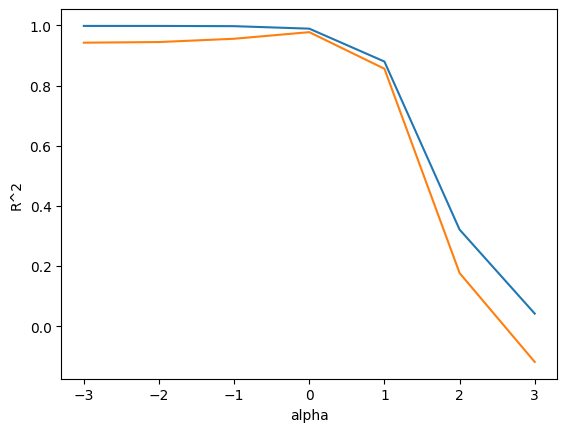

In [ ]:
import matplotlib.pyplot as plt
train_score = []
test_score = []

alpha_list = [0.001,0.01,0.1,1,10,100,1000]
for alpha in alpha_list:
  ridge = Ridge(alpha = alpha)
  ridge.fit(train_scaled, train_target)

  train_score.append(ridge.score(train_scaled, train_target))
  test_score.append(ridge.score(test_scaled, test_target))

import numpy as np
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [ ]:
print(test_score)

[0.9422715186685238, 0.9443748021189575, 0.9553354967756778, 0.9772522995224812, 0.8556356929317945, 0.17689055982993074, -0.1184317339903238]


In [ ]:
ridge = Ridge(alpha = 1)  #alpha = 1 (log스케일로 0)일 때 최적의 성능을 갖는 것으로 그래프에서 도출되었다.
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))
#릿지 회귀 최적 성능

0.9888860272733656
0.9772522995224812


디폴트로 설정된 알파(1)이 가장 높은 성능을 나타냈다.

##릿지 회귀 모델을 적용한 코로나 사망인구 예측

In [ ]:
#예측값 도출

#input_data = [[beds, doctor, nurs, nurs_assist, ambulance, covid_infection, emergency_center]]순서
input_data = [[19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30]]  #부산광역시(morality: 212) 와 유사하나 약간 높은 예시 input을 투입

# 정규화
input_data_scaled = scaler.transform(input_data)

# 예측값 도출 ridge.predict
predicted_mortality = ridge.predict(input_data_scaled)

# morality 출력
print("예측된 코로나로 인한 사망인구:", predicted_mortality[0])
# 결과: 246.1397875178415, 신뢰성 있는 값이 출력되었다.

예측된 코로나로 인한 사망인구: 246.1397875178415


#라쏘 회귀

##라쏘 회귀 모델 적용

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9973524181144665
0.9557087459673375


##가장 뛰어난 성능의 alpha값 확인하기

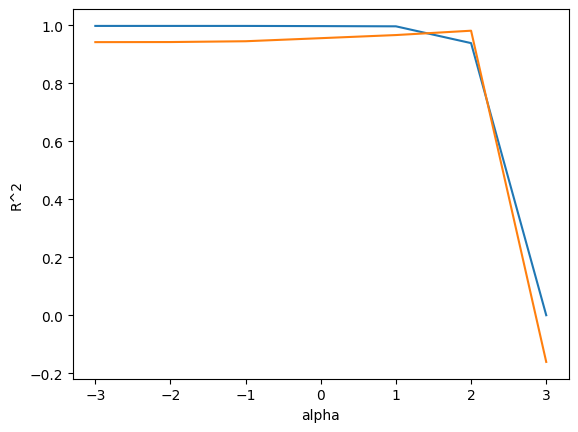

In [ ]:
train_score = []
test_score = []

alpha_list = [0.001,0.01,0.1,1,10,100,1000]
for alpha in alpha_list:
  lasso = Lasso(alpha = alpha)
  lasso.fit(train_scaled, train_target)

  train_score.append(lasso.score(train_scaled, train_target))
  test_score.append(lasso.score(test_scaled, test_target))

import numpy as np
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

alpha 값이 1~2일 때 가장 train score와 test scrore 간의 차이가 적고, alpha = 100^2 이후에는 급격히 두 score모두가 낮아진다.

두 규제를 모두 적용한 결과, Linear Regression과 규제 추가 전 다중회귀 모델보다 성능이 상승되었다.

In [ ]:
lasso = Lasso(alpha = 32)  #앞선 그래프에서 도출된 최적의 alpha값인 10의 1.5승 = 약 32
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))
#라쏘 회귀의 최적 성능

0.9911751265696557
0.9843031564977851


##라쏘 회귀 모델을 적용한 코로나 사망 인구 예측

In [ ]:
#input_data = [[beds, doctor, nurs, nurs_assist, ambulance, covid_infection, emergency_center]]순서
input_data = [[19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30]]  #부산광역시(morality: 212) 와 유사하나 약간 높은 예시 input 투입

# 정규화
input_data_scaled = scaler.transform(input_data)

# 예측값 도출 lasso.predict
predicted_mortality = lasso.predict(input_data_scaled)

# morality 출력
print("예측된 코로나로 인한 사망인구:", predicted_mortality[0])
#결과: 212.7227876480062로 신뢰성이 높다.
#참고: 릿지 회귀 결과는 246.1397875178415 였다.

예측된 코로나로 인한 사망인구: 212.7227876480062


#Ridge, Lasso coef 확인

In [ ]:
lasso.coef_

array([ -0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        , 380.85176057,   0.        ])

In [ ]:
ridge.coef_

array([-51.41174524,  53.98269999, -24.61810674, -10.68883542,
       -32.64575157, 271.50915199, 119.62739117])

#직접 데이터를 투입하여 코로나 사망 인구를 예측해보기

In [ ]:
#test1
#사용자에게 데이터를 입력받아 이중리스트로 변환
usr_input = input("(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30): ") #콤마로 구분
input_lst = usr_input.split(",")
input_lst = [[float(x) for x in input_lst]]
print(input_lst)

# 정규화
input_data_scaled = scaler.transform(input_lst)

# 예측값 도출 ridge.predict
ridge_predicted_mortality = ridge.predict(input_data_scaled)

# 예측값 도출 lasso.predict
lasso_predicted_mortality = lasso.predict(input_data_scaled)

# morality 출력
print("릿지 회귀모형으로 예측된 코로나로 인한 사망인구:", ridge_predicted_mortality[0])
print("라쏘 회귀모형으로 예측된 코로나로 인한 사망인구:", lasso_predicted_mortality[0])

(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30): 19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30
[[19.1, 1.5, 5.65, 3.0, 12.3, 25100.0, 30.0]]
릿지 회귀모형으로 예측된 코로나로 인한 사망인구: 246.1397875178415
라쏘 회귀모형으로 예측된 코로나로 인한 사망인구: 212.7227876480062


In [ ]:
#test2
usr_input = input("(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30): ") #콤마로 구분
input_lst = usr_input.split(",")
input_lst = [[float(x) for x in input_lst]]
print(input_lst)

# 정규화
input_data_scaled = scaler.transform(input_lst)

# 예측값 도출 ridge.predict
ridge_predicted_mortality = ridge.predict(input_data_scaled)

# 예측값 도출 lasso.predict
lasso_predicted_mortality = lasso.predict(input_data_scaled)

# morality 출력
print("릿지 회귀모형으로 예측된 코로나로 인한 사망인구:", ridge_predicted_mortality[0])
print("라쏘 회귀모형으로 예측된 코로나로 인한 사망인구:", lasso_predicted_mortality[0])

(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100): 14.2, 1.5, 6.78, 2.0, 10.4, 20000.0, 15
[[14.2, 1.5, 6.78, 2.0, 10.4, 20000.0, 15.0]]
릿지 회귀모형으로 예측된 코로나로 인한 사망인구: 150.37294713434437
라쏘 회귀모형으로 예측된 코로나로 인한 사망인구: 169.8012907472546


In [ ]:
#test3
usr_input = input("(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100, 30): ") #콤마로 구분
input_lst = usr_input.split(",")
input_lst = [[float(x) for x in input_lst]]
print(input_lst)

# 정규화
input_data_scaled = scaler.transform(input_lst)

# 예측값 도출 ridge.predict
ridge_predicted_mortality = ridge.predict(input_data_scaled)

# 예측값 도출 lasso.predict
lasso_predicted_mortality = lasso.predict(input_data_scaled)

# morality 출력
print("릿지 회귀모형으로 예측된 코로나로 인한 사망인구:", ridge_predicted_mortality[0])
print("라쏘 회귀모형으로 예측된 코로나로 인한 사망인구:", lasso_predicted_mortality[0])

(인구 천 명당) 침상 수, 의사, 간호사, 간호조무사, 구급차, 발생인구를 입력해주세요(예시: 19.1, 1.5, 5.65, 3.0, 12.3, 25100): 25.5, 2.4, 7.43, 4.1, 15.5, 35000.0, 20
[[25.5, 2.4, 7.43, 4.1, 15.5, 35000.0, 20.0]]
릿지 회귀모형으로 예측된 코로나로 인한 사망인구: 259.21751890800397
라쏘 회귀모형으로 예측된 코로나로 인한 사망인구: 296.0409875141711


릿지 회귀 모델과 라쏘 회귀 모델 사이의 예측값이 신뢰성 있는 값을 보인다.